In [10]:
import torch
import numpy as np

test_input = np.array([[0, 0, 0],
                       [0, 1, 1],
                       [2, 2, 2]])

v_kernel = np.array([[1, 1, 1],
                    [0, 0, 0],
                    [-1, -1, -1]], dtype=np.float32)

h_kernel = np.array([[-1, 0, 1],
                     [-1, 0, 1],
                     [-1, 0, 1]], dtype=np.float32)

b_kernel = np.array([[0.2, 0.2, 0.2],
                     [0.2, 0.2, 0.2],
                     [0.2, 0.2, 0.2]], dtype=np.float32)

In [11]:
def apply_kernel(img, kernel):
    return np.sum(np.multiply(img, kernel))

apply_kernel(test_input, v_kernel)

-6.0

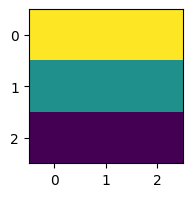

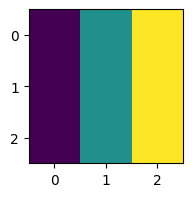

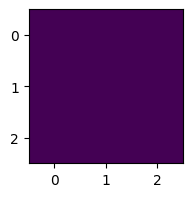

In [12]:
import matplotlib.pyplot as plt
import cv2

def show_cv2_img(img, figsize = (4, 4)):
    plt.figure(figsize = figsize)
    plt.imshow(img)
    plt.show()

show_cv2_img(v_kernel, figsize=(2, 2))
show_cv2_img(h_kernel, figsize=(2, 2))
show_cv2_img(b_kernel, figsize=(2, 2))

In [13]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils import data 

directory = "./data/imagenet_test/"
dataset = datasets.ImageFolder(directory)

len(dataset)

1

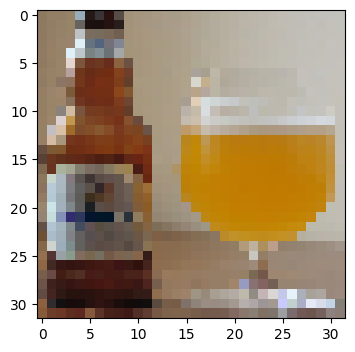

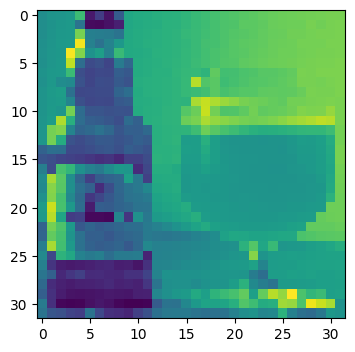

In [15]:
SIZE = (32, 32)

idx = 0
img = np.array(dataset[idx][0])

img = cv2.resize(img, SIZE)
img = np.float32(img / 255)

g_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

show_cv2_img(img)
show_cv2_img(g_img)

In [17]:
img_batch = img.transpose((2, 0, 1))
img_batch = np.array([img_batch])

g_img_batch = np.array([[g_img]])

v_kernel_batch = np.array([[v_kernel]])
h_kernel_batch = np.array([[h_kernel]])
b_kernel_batch = np.array([[b_kernel]])

img_batch.shape, g_img_batch.shape, v_kernel_batch.shape

((1, 3, 32, 32), (1, 1, 32, 32), (1, 1, 3, 3))

### Simple case: apply conv for grayscale image

In [21]:
def custom_conv2d(img, kernel):
    img_ch, img_w, img_h = img.shape
    k_ch, k_w, k_h = kernel.shape
    
    if img_ch != k_ch:
        print('Input/kernel channels dont match')
        return
    
    w, h = img_w - k_w + 1, img_h - k_h + 1    
    
    out = np.zeros((w, h))
    for r in range(h):
        for c in range(w):
            window = img[:, r : r + k_h, c : c + k_w]
            out[r][c] = apply_kernel(window, kernel)
            
    return out

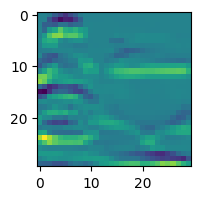

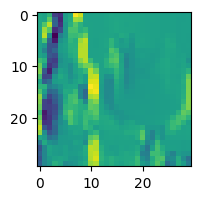

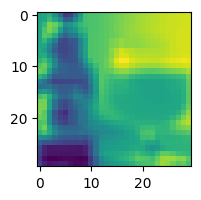

In [27]:
conv_v_img = custom_conv2d(g_img_batch[0], v_kernel_batch[0])
conv_h_img = custom_conv2d(g_img_batch[0], h_kernel_batch[0])
conv_b_img = custom_conv2d(g_img_batch[0], b_kernel_batch[0])

show_cv2_img(conv_v_img, (2, 2))
show_cv2_img(conv_h_img, (2, 2))
show_cv2_img(conv_b_img, (2, 2))

#### Compare with torch implementation

In [28]:
import torch.nn as nn
import torch.nn.functional as F

weights = torch.from_numpy(v_kernel_batch)
weights.requires_grad = False

# create Conv layer with predefined kernel
conv_layer = nn.Conv2d(1, 1, (3, 3), bias=False)

with torch.no_grad():
    conv_layer.weight = nn.Parameter(weights)
    
for p in conv_layer.parameters():
    p.requires_grad = False
    print(p)

Parameter containing:
tensor([[[[ 1.,  1.,  1.],
          [ 0.,  0.,  0.],
          [-1., -1., -1.]]]])


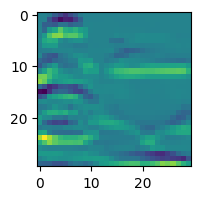

(None, (30, 30))

In [31]:
x = torch.from_numpy(g_img_batch)

out = conv_layer(x)
out = out[0][0].numpy()

show_cv2_img(out, (2, 2)), out.shape

In [32]:
diff = out - conv_v_img

np.allclose(out, conv_v_img), np.amax(diff)

(False, 1.1920928955078125e-07)

### Apply conv for RGB image

In [33]:
def custom_conv(batch, kernel):
    bs, img_ch, img_w, img_h = batch.shape
    k_count, k_ch, k_w, k_h = kernel.shape
    
    if img_ch != k_ch:
        print('Different channels input')
        return
    
    w, h = img_w - k_w + 1, img_h - k_h + 1    
    
    out = np.zeros((bs, k_count, w, h))
    
    for b_id in range(bs):
        current_sample = batch[b_id]

        for ch in range(k_count):
            current_kernel = kernel[ch]

            for row in range(h):
                for col in range(w):
                    window = current_sample[:, row : row + k_h, col : col + k_w]
                    out[b_id][ch][row][col] = apply_kernel(window, current_kernel)

    return out

In [47]:
INPUT_SHAPE = (3, 32, 32)
KERNEL_SIZE = (3, 3)

batch_size = 1
in_channels = INPUT_SHAPE[0]
out_channels = 2

INPUT_BATCH = (batch_size, ) + INPUT_SHAPE
KERNEL_SHAPE = (out_channels, in_channels, KERNEL_SIZE[0], KERNEL_SIZE[1])

#rnd_img = (np.random.random(INPUT_BATCH) * 2 - 1).astype(np.float32) # (1, 3, 32, 32)
rnd_kernel = (np.random.random(KERNEL_SHAPE) * 2 - 1).astype(np.float32)

rnd_kernel.shape

(2, 3, 3, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


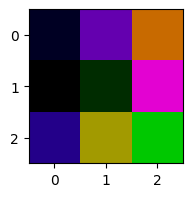

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


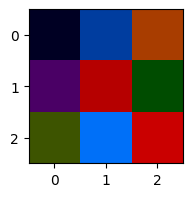

In [48]:
for ch in rnd_kernel:
    show_cv2_img(ch, (2, 2))

(1, 2, 30, 30)


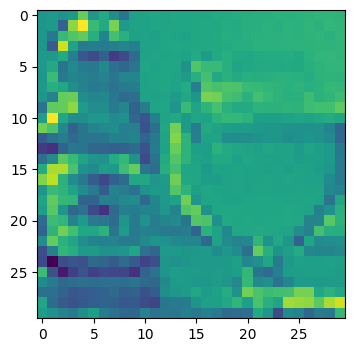

float64 1.6354840993881226 -0.5984974503517151


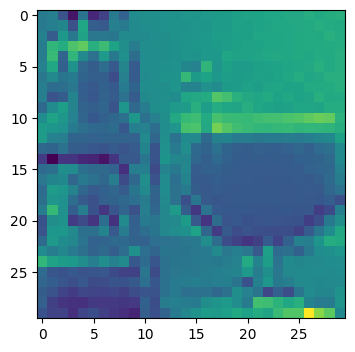

float64 1.9052340984344482 -0.19661282002925873


In [51]:
out_manual = custom_conv(img_batch, rnd_kernel)
print(out_manual.shape)

for a_map in out_manual[0]:
    show_cv2_img(a_map)
    print(a_map.dtype, np.amax(a_map), np.amin(a_map))

#### Compare with torch implementation

In [52]:
x = torch.from_numpy(rnd_img)
weights = torch.from_numpy(rnd_kernel)

In [53]:
conv_layer = nn.Conv2d(in_channels, out_channels, KERNEL_SIZE, bias=False)

with torch.no_grad():
    weights.requires_grad = False
    conv_layer.weight = nn.Parameter(weights)
    
for p in conv_layer.parameters():
    p.requires_grad = False
    print(p.shape)

torch.Size([2, 3, 3, 3])


torch.Size([1, 3, 32, 32]) torch.Size([1, 2, 30, 30])


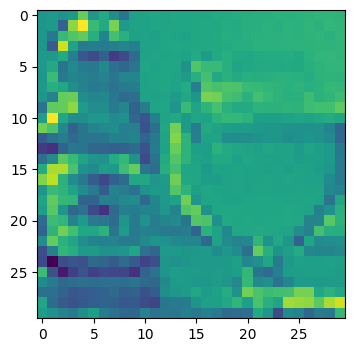

In [54]:
x = torch.from_numpy(img_batch)
out = conv_layer(x)

print(x.shape, out.shape)
show_cv2_img(out_manual[0][0])

In [55]:
diff = out_manual - out.numpy()
np.allclose(out_manual, out.numpy()), np.amin(diff), np.amax(diff)

(False, -4.76837158203125e-07, 4.76837158203125e-07)

### Third-party implementation

In [61]:
test_img = img_batch
test_kernel = rnd_kernel

print(test_img.shape, test_kernel.shape)
print(test_img.dtype, np.amax(test_img), np.amin(test_img))
print(test_kernel.dtype, np.amax(test_kernel), np.amin(test_kernel))

(1, 3, 32, 32) (2, 3, 3, 3)
float32 0.9882353 0.0
float32 0.97587234 -0.92158073


In [62]:
import numpy as np
from scipy import signal

def conv2d_simplified(inp, weight, bias=None, padding=0):
    # This is an implemention of torch's conv2d using scipy correlate2d. Only
    # limited options are supported for simplicity.
    # Inspired by https://github.com/99991/NumPyConv2D/
    c_out, c_in_by_groups, kh, kw = weight.shape
    if not isinstance(padding, int):
        raise NotImplementedError()
    
    if padding:
        inp = np.pad(inp, ((0, 0), (0, 0), (padding, padding), (padding, padding)), "constant")

    outArr = np.empty((inp.shape[0], c_out, inp.shape[2]+1-kh, inp.shape[3]+1-kw))
    al = np.empty((outArr.shape[2], outArr.shape[3]))

    for k in range(inp.shape[0]):
        for i in range(weight.shape[0]):
            al[:, :] = 0.0

            for j in range(weight.shape[1]):
                al += signal.correlate2d(inp[k, j, :, :], weight[i, j, :, :], 'valid')

            outArr[k, i, :, :] = al

    if bias is not None:
        outArr = outArr + bias.reshape(1, c_out, 1, 1)

    return outArr

In [63]:
conv = conv2d_simplified(test_img, test_kernel)
conv.shape

(1, 2, 30, 30)

In [64]:
diff = conv - out.numpy()
np.allclose(conv, out.numpy()), np.amin(diff), np.amax(diff)

(False, -4.172325134277344e-07, 4.470348358154297e-07)

In [65]:
diff = conv - out_manual
np.allclose(conv, out), np.amin(diff), np.amax(diff)

(False, -3.5762786865234375e-07, 3.5762786865234375e-07)